## 4.5. 权重衰减
[正则化的原理，通过最小化权重向量](https://zh.d2l.ai/chapter_multilayer-perceptrons/weight-decay.html#sec-weight-decay)

与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。 较小的入值对应较少约束的w， 而较大的入值对w的约束更大。



### 4.5.1. 高维线性回归

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

/home/mkid/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811748419/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


[生成数据的公式](https://zh.d2l.ai/chapter_multilayer-perceptrons/weight-decay.html#id2)

我们选择标签是关于输入的线性函数。 标签同时被均值为0，标准差为0.01高斯噪声破坏。 为了使过拟合的效果更加明显，我们可以将问题的维数增加到d=200， 并使用一个只包含20个样本的小训练集。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 4.5.2. 从零开始实现

下面我们将从头开始实现权重衰减，只需将L2的平方惩罚添加到原始目标函数中。

#### 4.5.2.1. 初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

#### 4.5.2.2. 定义L2范数惩罚

In [4]:
def l2_penalty(w):  # 入/2*w^2
    return torch.sum(w.pow(2)) / 2

#### 4.5.2.3. 定义训练代码实现

In [7]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss # lambda arguments : expression(一般是函数)
    num_epochs, lr = 100, 0.003
    # xlim: 表示x轴的刻度,[0, 5, 10, ..., 100]
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            # 训练和测试的准确率
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), (d2l.evaluate_loss(net, test_iter, loss))))
    print('w的L2范数是：', torch.norm(w).item())

#### 4.5.2.4. 忽略正则化直接训练
我们现在用lambd = 0禁用权重衰减后运行这个代码。 注意，这里训练误差有了减少，但测试误差没有减少， 这意味着出现了严重的过拟合。

w的L2范数是： 14.44157886505127


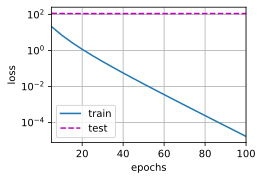

In [8]:
train(lambd=0)

#### 4.5.2.5. 使用权重衰减

w的L2范数是： 0.3935849964618683


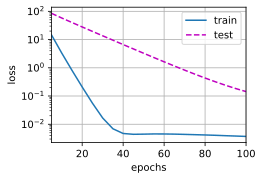

In [9]:
train(lambd=3)

### 4.5.3. 简洁实现

在下面的代码中，我们在实例化优化器时直接通过weight_decay指定weight decay超参数。 默认情况下，PyTorch同时衰减权重和偏移。 这里我们只为权重设置了weight_decay，所以偏置参数b不会衰减。

`reduction='none'`：求所有对应位置的差的平方，返回的仍然是一个和原来形状一样的矩阵。

`reduction='mean'`：求所有对应位置差的平方的均值，返回的是一个标量。

`reduction='sum'`：求所有对应位置差的平方的和，返回的是一个标量。

In [11]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()    # 参数归一化，加速计算
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    tariner = torch.optim.SGD([
        {"params": net[0].weight, 'weight_decay': wd}
        ])
    

SyntaxError: unexpected EOF while parsing (<ipython-input-11-4b58c8f57410>, line 3)